<a href="https://colab.research.google.com/github/akshayonly/ML-Antioxidant-Antibacterial-IC50/blob/main/ML_Antioxidant_Antibacterial_IC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pubchempy
! pip install biopython

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13835 sha256=498d84c25adfdcbba7b76c4fd62c27e06f401685d89ad2cb77e653c38224e0cd
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built pubchempy
     |████████████████████████████████| 2.3 MB 36.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import pubchempy as pcp
import re
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
smiles_compounds = list()

with open("/content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/SMILES.txt", "r") as file:

  for lines in file:

    smile = lines.split('\t')[0].rstrip()
    comp = lines.split('\t')[1].rstrip()

    smiles_compounds.append((comp, smile))

In [4]:
smiles_compounds = np.array(smiles_compounds)

In [5]:
data = pd.DataFrame(smiles_compounds, columns=['CompName', 'SMILES'])

In [6]:
data.head()

,CompName,SMILES
0,Apigenin-6-C-glucoside,O=C1C=C(C3=CC=C(O[H])C=C3)OC2=C1C(O[H])=C([C@@...
1,Argentinine,CN(C)CCC1=CC(O[H])=C(OC)C3=C1C=CC2=CC=CC=C23
2,Catechin,[H]OC1=C2C(O[C@@H]([C@]3=CC(O[H])=C(O[H])C=C3)...
3,Epicatechin,[H]OC1=C2C(O[C@H]([C@]3=CC(O[H])=C(O[H])C=C3)[...
4,Homoorientin,O=C1C=C(C3=CC(O[H])=C(O[H])C=C3)OC2=C1C(O[H])=...


In [7]:
data.SMILES[22]

'O=C1C(C[C@H](O)CCCCC[C@@H](O)CCCC[C@@H](O)C2O[C@@H]([C@H](O)CCCCCCCCCCCC)CC2)=C[C@H](C)O1'

In [8]:
def PubChemCID(SMILE):
  """
  Returns PubChem CID (ID) of given compound by SMILE
  """
  cid = pcp.get_compounds(SMILE, 'smiles')
  cid_extracted = re.findall(r'\d+', str(cid[0]))

  if len(cid_extracted)>=1:
    return cid_extracted[0]
  else:
    return str("IDENTICAL_COMPOUND_ABSENT")

In [9]:
meta_data = list()

for name, smile in tqdm(zip(data.CompName, data.SMILES)):

  pubcid = PubChemCID(smile)

  if pubcid != 'IDENTICAL_COMPOUND_ABSENT':

    compound = pcp.Compound.from_cid(pubcid)

    comp_logp = np.float32(compound.xlogp)

    ele_charge = np.float32(compound.charge)

    mol_mass = np.float32(compound.exact_mass)

    rotat_bond = int(compound.rotatable_bond_count)

    iso_smile = compound.isomeric_smiles

    h_acceptor = int(compound.h_bond_acceptor_count)

    h_donor = int(compound.h_bond_donor_count)

    fingerprint = compound.fingerprint

    heavy_atom = int(compound.heavy_atom_count)

    cac_fingerprint = compound.cactvs_fingerprint

    can_smile = compound.canonical_smiles

    meta_data.append((pubcid, name, heavy_atom, rotat_bond, ele_charge, 
                      mol_mass, h_donor, h_acceptor, comp_logp, 
                      can_smile, iso_smile, cac_fingerprint))
  else:
    print(pubcid, name)

23it [00:13,  1.95it/s]

IDENTICAL_COMPOUND_ABSENT Annonacin


31it [00:17,  1.80it/s]


In [10]:
meta_data = np.array(meta_data)

In [11]:
column_names = ['PubChem_CID', 'CompName', 'Heavy_Atom', 'Rotat_Bond', 'Ele_Charge',
                        'Mol_Mass', 'H_Donor', 'H_Acceptor', 'XLogP',
                        'Can_SMILE', 'Iso_SMILE', 'Cac_Fingerprint']

In [12]:
compounds_meta_data= pd.DataFrame(meta_data, columns=column_names)

In [13]:
compounds_meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PubChem_CID      30 non-null     object
 1   CompName         30 non-null     object
 2   Heavy_Atom       30 non-null     object
 3   Rotat_Bond       30 non-null     object
 4   Ele_Charge       30 non-null     object
 5   Mol_Mass         30 non-null     object
 6   H_Donor          30 non-null     object
 7   H_Acceptor       30 non-null     object
 8   XLogP            30 non-null     object
 9   Can_SMILE        30 non-null     object
 10  Iso_SMILE        30 non-null     object
 11  Cac_Fingerprint  30 non-null     object
dtypes: object(12)
memory usage: 2.9+ KB


In [14]:
compounds_meta_data["Heavy_Atom"] = compounds_meta_data["Heavy_Atom"].astype('int32')
compounds_meta_data["Rotat_Bond"] = compounds_meta_data["Rotat_Bond"].astype('int32')
compounds_meta_data["Ele_Charge"] = compounds_meta_data["Ele_Charge"].astype('float32')
compounds_meta_data["Mol_Mass"] = compounds_meta_data["Mol_Mass"].astype('float32')
compounds_meta_data["H_Donor"] = compounds_meta_data["H_Donor"].astype('int32')
compounds_meta_data["H_Acceptor"] = compounds_meta_data["H_Acceptor"].astype('int32')
compounds_meta_data["XLogP"] = compounds_meta_data["XLogP"].astype('float32')

In [15]:
compounds_meta_data.describe()

,Heavy_Atom,Rotat_Bond,Ele_Charge,Mol_Mass,H_Donor,H_Acceptor,XLogP
count,30.00000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,24.50000,3.666667,0.0,342.219574,4.700000,7.166667,1.270000
std,10.09182,3.546084,0.0,144.977921,3.120013,4.676304,2.835751
min,11.00000,0.000000,0.0,150.104462,0.000000,1.000000,-5.000000
25%,20.00000,1.000000,0.0,265.614197,2.250000,4.000000,-0.575000
50%,22.00000,3.000000,0.0,302.042664,4.000000,6.000000,1.050000
75%,31.00000,4.750000,0.0,431.674507,7.750000,10.750000,2.600000
max,43.00000,16.000000,0.0,610.153381,10.000000,16.000000,10.700000


In [16]:
compounds_meta_data.to_excel("compounds_molecular_properties_meta_data.xlsx", 
                             sheet_name='IC50-Missing')  

In [17]:
! cp -r /content/compounds_molecular_properties_meta_data.xlsx /content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/

In [18]:
compounds_meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PubChem_CID      30 non-null     object 
 1   CompName         30 non-null     object 
 2   Heavy_Atom       30 non-null     int32  
 3   Rotat_Bond       30 non-null     int32  
 4   Ele_Charge       30 non-null     float32
 5   Mol_Mass         30 non-null     float32
 6   H_Donor          30 non-null     int32  
 7   H_Acceptor       30 non-null     int32  
 8   XLogP            30 non-null     float32
 9   Can_SMILE        30 non-null     object 
 10  Iso_SMILE        30 non-null     object 
 11  Cac_Fingerprint  30 non-null     object 
dtypes: float32(3), int32(4), object(5)
memory usage: 2.1+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd36355c190>,
      dtype=object)

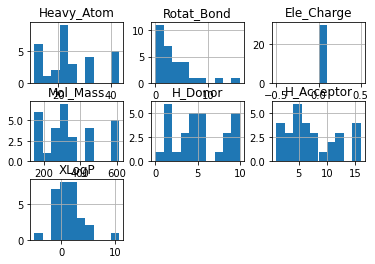

In [19]:
compounds_meta_data.hist()

**NOTE:**

1. Does ChemDraw converts structures to SMILE differently? The compounds info after search by their name has different SMILE structure from what you have given in the .txt file

In [20]:
fingerprint_values = np.zeros([len(compounds_meta_data), len(compounds_meta_data.Cac_Fingerprint[0])])

for idx_i, fingerprint in tqdm(enumerate(compounds_meta_data.Cac_Fingerprint)):
  for idx_j, letter in enumerate(fingerprint):
    fingerprint_values[idx_i][idx_j] = np.int(letter)

30it [00:00, 1623.31it/s]


In [21]:
column_names_finger = [f"fp{idx}" for idx in range(len(compounds_meta_data.Cac_Fingerprint[0]))]

compounds_feature_subset_2 = pd.DataFrame(fingerprint_values, columns=column_names_finger)

compounds_feature_subset_1 = compounds_meta_data[['Heavy_Atom', 'Rotat_Bond', 'H_Donor', 'H_Acceptor', 'XLogP']]

final_features = np.array(pd.concat([compounds_feature_subset_1, 
                            compounds_feature_subset_2],
                           axis=1))

In [22]:
final_features

array([[31.,  3.,  7., ...,  0.,  0.,  0.],
       [22.,  4.,  1., ...,  0.,  0.,  0.],
       [21.,  1.,  5., ...,  0.,  0.,  0.],
       ...,
       [31., 12.,  1., ...,  0.,  0.,  0.],
       [12.,  2.,  4., ...,  0.,  0.,  0.],
       [22., 16.,  4., ...,  0.,  0.,  0.]])

In [23]:
minmax = MinMaxScaler()

In [24]:
X = minmax.fit_transform(final_features)

y = np.array(compounds_meta_data['Mol_Mass']).reshape(-1, 1)
y = minmax.fit_transform(y)

In [25]:
X.shape

(30, 886)

In [26]:
y.shape

(30, 1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

# LinearRegression

In [28]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

score = linreg.score(X_train, y_train)
print("R-squared:", score)

# cv_score = cross_val_score(lsvr, x, y, cv=5)
# print("CV mean score: ", cv_score.mean())

y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

R-squared: 1.0
MSE:  0.03017317167334852
RMSE:  0.17370426498318492


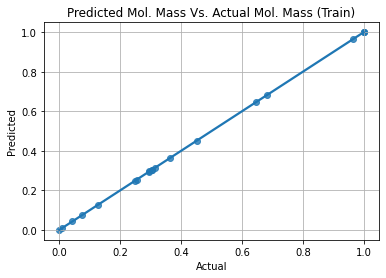

In [29]:
sns.regplot(x=y_train, y=linreg.predict(X_train))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted Mol. Mass Vs. Actual Mol. Mass (Train)')
plt.savefig('pred_act_train_molecular_mass.jpg')
plt.show()

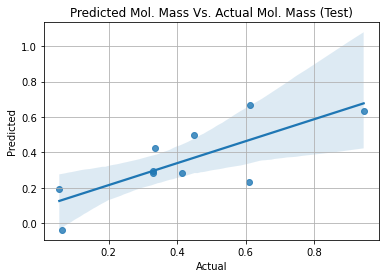

In [30]:
sns.regplot(x=y_test, y=linreg.predict(X_test))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted Mol. Mass Vs. Actual Mol. Mass (Test)')
plt.savefig('pred_act_test_molecular_mass.jpg')
plt.show()

# SGD LinearRegression

In [31]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(penalty='l1', alpha=0.001)

sgd.fit(X_train, y_train)

score = sgd.score(X_train, y_train)
print("R-squared:", score)

# cv_score = cross_val_score(lsvr, x, y, cv=5)
# print("CV mean score: ", cv_score.mean())

y_pred = sgd.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

R-squared: 0.9597262594626277


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

MSE:  0.039338103250133184
RMSE:  0.19833835546896417


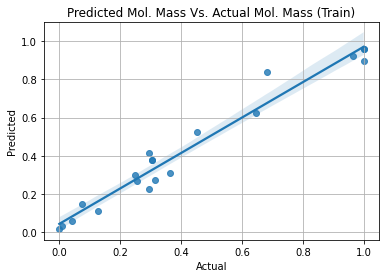

In [33]:
sns.regplot(x=y_train, y=sgd.predict(X_train))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted Mol. Mass Vs. Actual Mol. Mass (Train)')
plt.savefig('pred_act_train_molecular_mass.jpg')
plt.show()

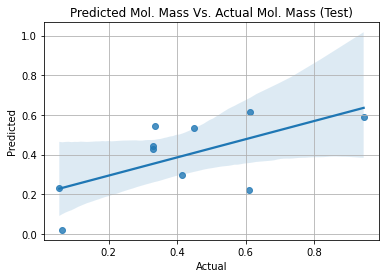

In [34]:
sns.regplot(x=y_test, y=sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted Mol. Mass Vs. Actual Mol. Mass (Test)')
plt.savefig('pred_act_test_molecular_mass.jpg')
plt.show()

# Neural Network


In [34]:
# To work

In [35]:
! mv *.jpg /content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/